In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')  # We will ignore warnings to avoid cluttering the notebook

import numpy as np

import windkit as wk
import pywasp as pw
from tutorial_helpers import *

# Evaluating roughness maps at Østerild

In this tutorial you will use several new features related to the treatment of roughness maps; these functionalities are not available in the WAsP GUI, but have been developed using the `pywasp` interface. 
Data from the Danish national test center for large wind turbines at Østerild will be used: there are two meteorological masts located to the north and south of a row of turbines (red and black points in figure below, respectively). The masts have measurements up to 244 m height, and are instrumented with both cup and sonic anemometers. The wind data used in this exercise are quality-controlled: periods where wakes and icing influenced the measurements have been removed. In addition, sectors that were influenced by the wakes of nearby turbines have been filtered out: this causes some sectors to have no observations (tripping a warning when reading the observed wind climates).

<figure>
<img src="images/osterild.jpg" alt="Source: innowind.dk" width="800p"  vspace="10"/>
    <figcaption> <em> Picture source: innowind.dk </em> </figcaption>
</figure>

Østerild wind data from Dec. 13th of 2016 to May 24th of 2018 (71802 10-min measurements) are used, with the following data and processing details: 
* data available from both northern and southern masts (red triangles in figure below);
* icing episodes removed by selecting data with standard deviation $\sigma_{U}>10^{-5}$m/s;
* flow distortion correction via “[Flow distortion on boom-mounted cup anemometers](https://backend.orbit.dtu.dk/ws/portalfiles/portal/5113326/ris-r-1738.pdf)” (P. Lindelöw-Marsden et al.);
* wind directions linearly interpolated between 40 and 244 m;
* data from sectors with wind turbine wakes were removed;
* 12-sector histogram files were already generated using `pywasp`.

<figure>
    <img src="images/osterild.png" alt="Source: Peña et al. (2019)" width="800p" vspace="10" />
    <figcaption> <em> Above figure source: Peña et al. (2019) </em> </figcaption>
</figure>


### Reading Østerild wind data
First we will read mast data from the two masts; these have been stored as multiple tab files, and are read using the "helper" function `read_tabfiles_oesterild` made for this tutorial.

In [3]:
tabs = read_tabfiles_oesterild()
print(tabs)

<xarray.Dataset>
Dimensions:       (point: 16, sector: 12, wsbin: 39)
Coordinates:
    height        (point) float64 10.0 40.0 70.0 106.0 ... 178.0 210.0 244.0
    crs           int8 0
    wsceil        (wsbin) float64 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
    wsfloor       (wsbin) float64 0.0 1.0 2.0 3.0 4.0 ... 35.0 36.0 37.0 38.0
  * wsbin         (wsbin) float64 0.5 1.5 2.5 3.5 4.5 ... 35.5 36.5 37.5 38.5
    sector_ceil   (sector) float64 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
    sector_floor  (sector) float64 345.0 15.0 45.0 75.0 ... 255.0 285.0 315.0
  * sector        (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
    west_east     (point) float64 4.928e+05 4.928e+05 ... 4.928e+05 4.928e+05
    south_north   (point) float64 6.323e+06 6.323e+06 ... 6.327e+06 6.327e+06
Dimensions without coordinates: point
Data variables:
    wdfreq        (sector, point) float64 0.0 0.0 0.0 ... 0.0407 0.04364 0.04703
    wsfreq        (wsbin, sector, point) float64 0.0 0.0 0

We note in the `Dimensions` of the `xarray.Dataset` that was read as `tabs` shows 16 `point`s; the first 8 points  correspond to the South mast, while the last 8 points correspond to the Northern mast.

These are binned wind climate files, whose format was explained earlier in the resource grid tutorial. 
I.e., there are no mean speeds, but rather probabilities (frequencies of occurence) per wind speed bin (`wsbin`) and directional `sector` stored in `wsfreq` (with directional probabilities over all speeds in `wdfreq`). 

# Preparing map files

Traditionally WAsP has only been able to use vector maps for roughness length. 
In `pywasp` it is very easy to work with both raster (grid) and vector (contour) maps, with simple functions to convert between formats. 

In this tutorial we'll load raster map files from a number of sources, in the following order: 
* **Danish Digital Terrain-elevation Map (DTM).** For the description of the terrain height we use the digital elevation model from Denmark's Geodatastyrelsen, at a resolution of 100 m (the full dataset was obtained via airplane-based lidar scans, and much finer resolutions can also be downloaded).
* **CORINE landcover.**  The European Union's CORINE initiative ('COoRdination of INformation on the Environment') is popular for wind resource assessments in Europe, due to its relatively fine resolution of 100 m (e.g. it is used for land cover in the New European Wind Atlas).
* **Sentinel satellite data.**  Through the INNOWIND project, which aims to use new information from satellites to create more accurate wind resource assessments, a new land cover product has been created.  It has 20 m resolution and provides not just landcover classes, but also tree height and leaf area index in forested areas.

In [6]:
elev_ras = wk.read_raster_map(os.path.join('data/maps','Oesterild_DTM_100m.grd'), map_type='elevation',crs=32632)

After reading the raster map of terrain elevation above, we now convert it to a vector map using the `pywasp.io.rastermap_to_vectormap` function previously outlined and used in the tutorial on resource grids.

In [7]:
elev_map = pw.rastermap_to_vectormap(elev_ras)

To load a raster map where each grid-cell (pixel) represents a roughness length, we can specify that we are loading a map of type `'roughness'` within the `read_rastermap` function. 
Internally `pywasp` always employs a vectormap where each contour has two integer values representing the land use classes on each side of the contour, along with a roughness look-up table that provides the $z_0$ associated with each class. 
This allows more detailed formulation of landcover, as we will see later in this tutorial; it also allows one to easily modify the roughness lengths in a project without operating on the map (as discussed in the earlier tutorial on resource grids).
> _**pywasp note**_: it is a _neccessary step_ for roughness data in raster format to be converted to vector representation (contours of roughness change) for the flow-perturbation calculations. `pywasp` can work with raster maps directly, but it is recommended to convert them to vectors first. 

In [9]:
corine_z0_ras, corine_lctable = wk.read_raster_map(os.path.join('data/maps','corine.grd'), map_type='roughness',crs=32632)
corine_z0_map, corine_lctable = pw.rastermap_to_vectormap(corine_z0_ras, lctable=corine_lctable)

# Using landcover (LC) maps

Above we loaded raster mapfiles with commonly-used elevation and roughness length data, and transformed them to vector format; along with reading the roughness lengths we converted them to landcover classes, also getting a corresponding lookup table. 

But what if we have LC maps, and not $z_0$?  This is actually the case for the Sentinel data. 

Below we see how to load a raster map of landcover and corresponding landcover tables, using the `pw.LandCoverTable.read_json` and `pw.read_rastermap` methods (the cells in the map represent landcover classes, which correspond to the $z_0$ in the lookup table).

This is done for both the CORINE data and the Sentinel data, along with converting each map to vector format:

In [11]:
corine_lctable = pw.LandCoverTable.read_json(os.path.join('data/maps','corine_DTU.json'))
corine_ras = wk.read_raster_map(os.path.join('data/maps','corine_lu.grd'), map_type='landcover',crs=32632)
corine_map, _ = pw.rastermap_to_vectormap(corine_ras, lctable=corine_lctable)

sentinel_lctable = pw.LandCoverTable.read_json(os.path.join('data/maps','scadis_sentinel.json'))
sentinel_ras = wk.read_raster_map(os.path.join('data/maps','sentinel.tif'), map_type='landcover', crs=32632)
sentinel_map, _ = pw.rastermap_to_vectormap(sentinel_ras, lctable=sentinel_lctable)

# Roughness and landcover around masts

Let's explore the maps that have been loaded, using the 'plot()' method of `xarray` (recalling that `'corine_ras'` is an xarray DataArray, and find the approximate roughness and landcover classes around the masts. 
We also use red dots to show the locations of the masts, which were contained in the `'tabs'` variable created by reading the wind data at the beginning of this tutorial.

In [12]:
x_mastS = tabs['west_east'][0]
x_mastN = tabs['west_east'][15]
y_mastS = tabs['south_north'][0]
y_mastN = tabs['south_north'][15]

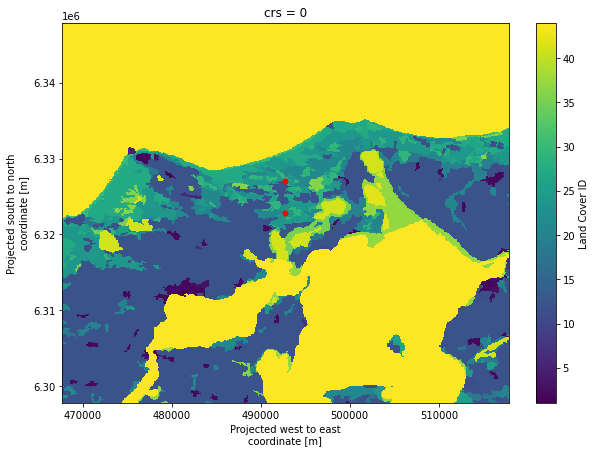

In [13]:
corine_ras.plot(figsize=(10,7))
plt.plot(x_mastN, y_mastN, 'or', ms=5)
plt.plot(x_mastS, y_mastS, 'or', ms=5)
plt.show()

we can zoom in more (limiting the plot area using `xlim` and `ylim`) and make the color bar discrete (noting there are 44 LC types in `'corine_ras'` and changing the color-map), to better see the LC's around the masts:

In [14]:
rzoom = 2500
my_cmap=plt.get_cmap('terrain', 44)
corine_ras.plot(figsize=(10,7), cmap=my_cmap)
plt.plot(x_mastN, y_mastN, 'or', ms=5)
plt.plot(x_mastS, y_mastS, 'or', ms=5)
plt.xlim([x_mastS - rzoom, x_mastS + rzoom])
plt.ylim([y_mastS - rzoom, y_mastN + rzoom])
plt.show()

From the CORINE map we can find out that much of the `LandCoverID` around the mast locations is 24, which according to the CORINE look-up table corresponds to "_Coniferous forest_" or `z0 = 1.2`. On the other hand, from the Sentinel map `LandCoverID` for the mast locations is 1, which corresponds to "_non-forest (cropland grassland other)_" or `z0 = 0.1`.

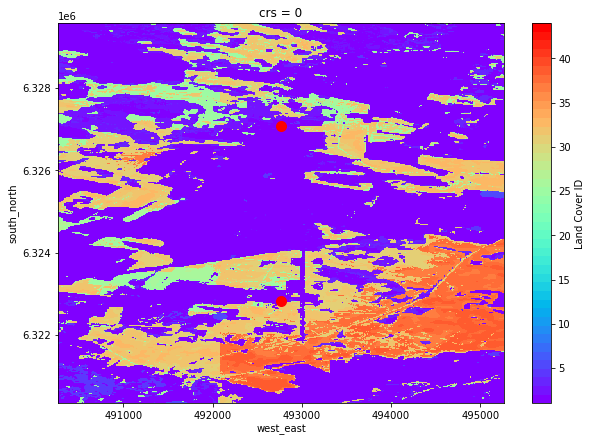

In [15]:
sentinel_ras.plot(figsize=(10,7), cmap=plt.get_cmap('rainbow', 44))
plt.plot(x_mastN, y_mastN, 'or', ms=10)
plt.plot(x_mastS, y_mastS, 'or', ms=10)
plt.xlim([x_mastS - rzoom, x_mastS + rzoom])
plt.ylim([y_mastS - rzoom, y_mastN + rzoom])
plt.show()

As seen above, the Sentinel data in this case appears to include much more detail than CORINE; e.g. we can see line-like features where the forests have been cut.  (Note: water is class 5 in the Sentinel lookup-table, where the classes are not ordered according to $z_0$. We have picked a different color table to accomodate this and make it blue. You can check the LC($z_0$) by simply looking at `sentinel_lctable`.)  

Now we combine the vector elevation map obtained earlier with the CORINE and Sentinel landcover vector maps and CORINE z0 vector map, and make a `TopographyMap` for each pair. 
Such combination of elevation and roughness/landcover maps is done, because they are both needed for the flow modelling in WAsP/`pywasp`. 
Here we store them in a dictionary (`'allmaps'`) for further processing:

In [19]:
allmaps = {}
allmaps['Sentinel landcover'] = pw.wasp.TopographyMap(elev_map, sentinel_map, sentinel_lctable)
allmaps['CORINE landcover']= pw.wasp.TopographyMap(elev_map, corine_map, corine_lctable)
allmaps['CORINE z0']= pw.wasp.TopographyMap(elev_map, corine_z0_map, corine_lctable)

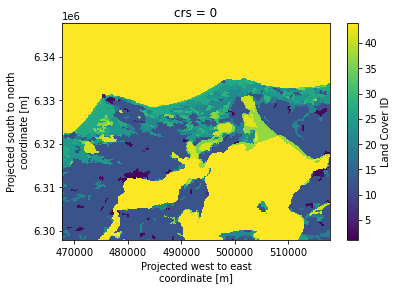

In [20]:
corine_ras.plot()
plt.show()

# Exploring roughness around a point: the roughness rose

WAsP's internal boundary layer (IBL) model computes speedup effects due to (a limited number of) the most significant roughness changes in each directional sector; this was discussed in the earlier tutorial on (py)WAsP's response to roughness changes. 
A roughness rose can be plotted, which displays the sector-wise $z_0$ as a function of distance. 

But to use WAsP's roughness-change model, and for displaying $z_0$-roses, we must set up `pywasp`'s configuration. This was also briefly covered/used in the resource_grid tutorial. 

Here we use the default WAsP configuration, but additionally employ the new landcover roughness model; the latter adds the ability to deal with displacement heights, i.e. treating flow that is "displaced" upward over forests based on mean tree height and leaf-area density (as found e.g. via Sentinel data). 

> **__pywasp note__**: WAsP has about 60 parameters and constants that can be changed to control the behaviour of its various submodels, most importly those involving terrain-induced perturbations, vertical extrapolation, and getting/applying generalized wind statistics. 

To get an overview of the settings of the various parameters, you can print the `conf.terrain` and `conf.climate` configurations. In practice we occasionally adjust only a small fraction of parameters from their default values, just as in WAsP, though further research and use of `pywasp` may change this; also, only some are actually visible to end-users. In-depth docummentation of them (beyond the European Wind Atlas, 1989) is currently under way, though one can use `getpardesc(pno)` for parameter number `pno` to get some description (done below).  

In [16]:
conf = set_config()
conf.terrain

Index  Parameter        Current       Default       Description
                        value         value
=====  ===============  ============  ===========   ==================================================
   31  decay_length     10000.000000  10000         Decay-length for importance of roughness relative to distance from center
   67  max_no_rgh          10.000000  10            Max number of roughness changes per sector.

In [18]:
conf.terrain.get_desc(67)

max_no_rgh
index          : 67              
standard_name  : max_no_of_roughness_changes
short_name     : max_no_rgh      
long_name      : max_no_of_roughness_changes_per_sector
concept_id     : MAXRC           
Rvea           : Rvea0287        
model          : IBL/roughness-change model
valid_min      : 1               
valid_max      : 20              
valid_range    : [1, 20]         
allowed_values : any value in valid range
default_value  : 10              

definition:
Max number of roughness changes per sector.

notes:
See Floors2018 for description and sensitivity. This array is dimensioned in 
the variable mrchs in dimpar.f90.



In [ ]:
conf.terrain.get_desc(31)

To see the roughness roses of all maps at a certain location we can do the following:
* loop over all maps stored in the dictionary `'allmaps'`
* use the `sel` method from xarray to select the first point in `tabs` (South mast, height = 10 m via `point=0`)
* _[also possible: select the site factors using the `to_point` method]_
* plot a roughness rose for each map

NOTE: we arbitrarily select from 10 m height, because the roughness rose does not depend on height

Sentinel landcover


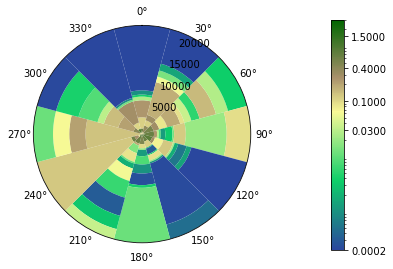

CORINE landcover


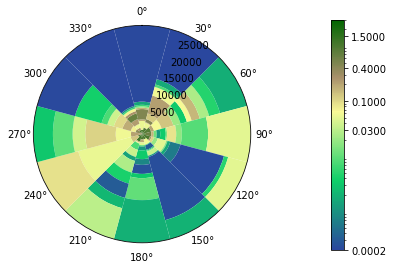

CORINE z0


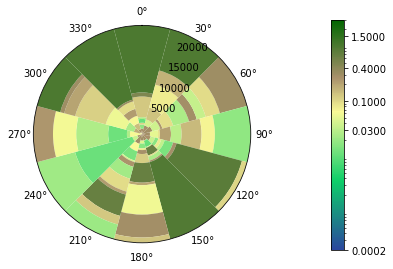

In [24]:
tabs0 = tabs.sel(point=0)
south_mast_loc = wk.create_dataset(
    tabs0.west_east, 
    tabs0.south_north, 
    tabs0.height, 
    wk.spatial.get_crs(tabs0)
)
for key, topo_map in allmaps.items():
    print(key)
    rou_rose, _ = topo_map.get_rou_rose(south_mast_loc, nsecs=12, conf=conf)
    wk.plot.roughness_rose(rou_rose)

# Comparison of observed and modelled wind, per roughness maps

We can now proceed with a comparison between the observed and modelled wind speed (and its distribution), using the WAsP model to vertically extrapolate the measurements from a certain height to another; the _wind profile_ and thus this extrapolation depends upon $z_0$. 

To start we first need to generalize the observed wind climate, after "cleaning" local terrain effects from the wind observations; then after downscaling the generalized wind climate, we re-apply local effects for another height or location. The processes are performed by the `generalize` and `downscale` methods, as shown in the earlier tutorial on resource maps.

Below we select observations from a certain height and mast and create a generalized wind climate (gwc) from them:
* the first argument is input binned wind climate (remember first 8 points correspond to the South mast, remaining to the North mast)
* the second argument is the mapfile that we want to use to generalize the observations
* the third argument is the WAsP model configuration
* the fourth and fifth argument set the generalized roughness and heights (see manual if you want to know more about this)


In [25]:
bwc = tabs.sel(point=3, drop=False) # Selecting wind data from the south mast at 106 m above ground level
gwc = pw.wasp.generalize(
    bwc, 
    allmaps['Sentinel landcover'], 
    conf,
    pw.wasp.set_z0s(0.3),
    pw.wasp.set_hgts(bwc.height.values, max(tabs.height))
    )

At line 128 of file ./modules/waspcore/Rvea0287/htrnsf_nt.f90
Fortran runtime warning: An array temporary was created
At line 128 of file ./modules/waspcore/Rvea0287/htrnsf_nt.f90
Fortran runtime warning: An array temporary was created
At line 132 of file ./modules/waspcore/Rvea0287/htrnsf_nt.f90
Fortran runtime warning: An array temporary was created
At line 132 of file ./modules/waspcore/Rvea0287/htrnsf_nt.f90
Fortran runtime warning: An array temporary was created


In [26]:
print(gwc)

<xarray.Dataset>
Dimensions:        (point: 1, sector: 12, gen_roughness: 5, gen_height: 5)
Coordinates:
    height         (point) float64 106.0
    south_north    (point) float64 6.323e+06
    west_east      (point) float64 4.928e+05
    crs            int8 0
    sector_ceil    (sector) float64 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
    sector_floor   (sector) float64 345.0 15.0 45.0 75.0 ... 255.0 285.0 315.0
  * sector         (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
  * gen_roughness  (gen_roughness) float64 0.0 0.001245 0.007746 0.04821 0.3
  * gen_height     (gen_height) float64 10.0 25.0 50.0 106.0 244.0
Dimensions without coordinates: point
Data variables:
    A              (sector, gen_height, gen_roughness, point) float32 6.858 ....
    k              (sector, gen_height, gen_roughness, point) float32 1.998 ....
    wdfreq         (sector, gen_roughness, point) float32 0.007756 ... 0.02462
Attributes:
    Conventions:      CF-1.8
    history:          T

## Horizontal transects of power density

Now that we have a generalized wind climate, we can reapply this wind climate for any nearby location. In this case we will create a horizontal transect of locations along a line connecting the meteorological masts, from 10 km south to 10 km north, at 106 m above ground level. The coordinates of the mast are taken from `bwc`. The output of the downscale function is a Weibull wind climate (`'wwc'`), i.e. sector-wise Weibull distributions at our transect.

In [29]:
loc_x = float(bwc.west_east)
loc_y = float(bwc.south_north)
half_ext = 10000.0 # half extent in x and y in m


points_y = np.arange(loc_y-10000,loc_y+10000,2000)
transect = wk.create_dataset(np.repeat(loc_x,len(points_y)), 
                          points_y, 
                          np.repeat(bwc.height.values,len(points_y)), 
                          32632)


wwc = pw.wasp.downscale(
    gwc,
    allmaps['Sentinel landcover'],
    transect,
    conf,
    genwc_interp='nearest'
    )

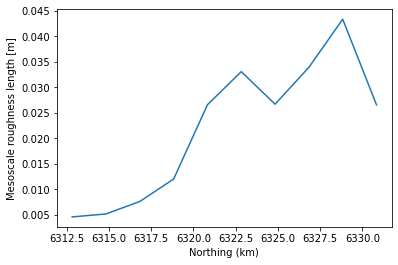

In [30]:
plot_transect_z0(tabs,transect,allmaps['CORINE landcover'],conf)

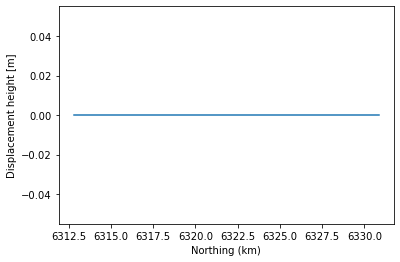

In [31]:
plot_transect_displ(tabs,transect,allmaps['CORINE landcover'],conf)

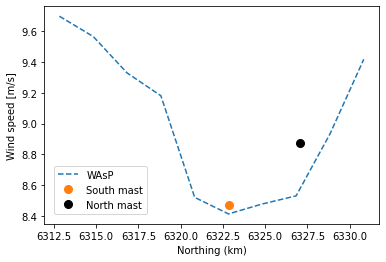

In [36]:
plot_transect_ws(tabs,wwc)

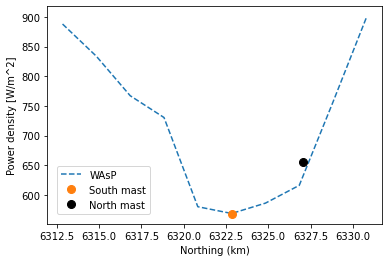

In [33]:
plot_transect_pd(tabs,wwc)

# Vertical profile of power density
Instead of a horizontal transect, we can also easily plot a vertical profile of the power density. For this a helper function `plot_profile` has been made available. It takes the same arguments as the `plot_transect_pd` function, i.e. the dataset of tabfiles and a Weibull wind climate. To do this we will:

* Use the `create_grid` function to create the output locations for the flow modelling
* Perform the downscaling step as described in the section "Validation of roughness maps". We can use the same generalized wind climate as before.
* Call the `plot_profile` function using the objects that have been created in the previous two steps

Let's do this first for the South mast:

In [38]:
print(tabs)

<xarray.Dataset>
Dimensions:        (point: 16, sector: 12, wsbin: 39)
Coordinates:
    height         (point) float64 10.0 40.0 70.0 106.0 ... 178.0 210.0 244.0
    crs            int8 0
    wsceil         (wsbin) float64 1.0 2.0 3.0 4.0 5.0 ... 36.0 37.0 38.0 39.0
    wsfloor        (wsbin) float64 0.0 1.0 2.0 3.0 4.0 ... 35.0 36.0 37.0 38.0
  * wsbin          (wsbin) float64 0.5 1.5 2.5 3.5 4.5 ... 35.5 36.5 37.5 38.5
    sector_ceil    (sector) float64 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
    sector_floor   (sector) float64 345.0 15.0 45.0 75.0 ... 255.0 285.0 315.0
  * sector         (sector) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
    west_east      (point) float64 4.928e+05 4.928e+05 ... 4.928e+05 4.928e+05
    south_north    (point) float64 6.323e+06 6.323e+06 ... 6.327e+06 6.327e+06
Dimensions without coordinates: point
Data variables:
    wdfreq         (sector, point) float64 0.0 0.0 0.0 ... 0.04364 0.04703
    wsfreq         (wsbin, sector, point) float64 0.0

In [40]:
loc_x = tabs.west_east.values[0]   # selecting the South mast x coordinate
loc_y = tabs.south_north.values[0] # selecting the South mast y coordinate
heights = tabs.height.values[:8]   # selecting the South mast heights

bwc_smast= tabs.isel(point=[0,1,2,3,4,5,6,7]) # South mast data

transect = wk.create_dataset(np.repeat(loc_x,len(heights)), 
                          np.repeat(loc_y,len(heights)), 
                          heights, 
                          32632)
wwc_south = pw.wasp.downscale(
    gwc, allmaps['Sentinel landcover'], transect, conf, genwc_interp='nearest' )

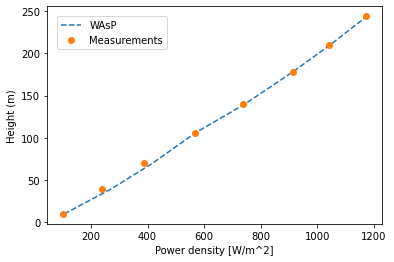

In [41]:
plot_profile(bwc_smast,wwc_south)

We will repeat the previous calculations for the North mast:

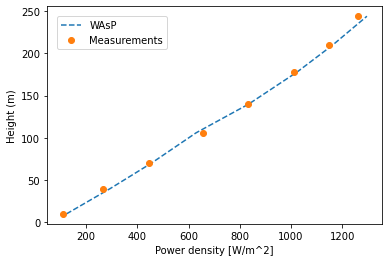

In [43]:
loc_xN = tabs.west_east.values[8]   # selecting the North mast x coordinate
loc_yN = tabs.south_north.values[8] # selecting the North mast y coordinate
heightsN = tabs.height.values[8:]   # selecting the North mast heights

bwc_nmast= tabs.isel(point=[8,9,10,11,12,13,14,15]) # North mast data

transect = wk.create_dataset(np.repeat(loc_xN,len(heights)), 
                          np.repeat(loc_yN,len(heights)), 
                          heightsN, 
                          32632)
wwc_north = pw.wasp.downscale(
    gwc,
    allmaps['Sentinel landcover'],
    transect,
    conf,
    genwc_interp='nearest'
    )

plot_profile(bwc_nmast,wwc_north)

# Changing properties of the landcover data

The advantage of using a landcover file together with a landcover table is that it easy to change the properties of the landcover. Let's start by showing the content of the CORINE landcover table that we loaded before:

In [44]:
print(corine_lctable)

id = LandCoverID
z0 = Roughness length (m)
d = Displacement height (m)
desc = Description
id	z0	d	desc
0	0.0000	0.0	no datanull
48	0.0000	0.0	no datanull
255	0.0000	0.0	no datanull
1	1.0000	0.0	Continuous urban fabric 111
2	0.8000	0.0	Discontinuous urban fabric 112
3	0.7000	0.0	Industrial or commercial units 121
4	0.1000	0.0	Road and rail networks and associated land 122
5	0.5000	0.0	Port areas 123
6	0.0100	0.0	Airports 124
7	0.0500	0.0	Mineral extraction sites 131
8	0.0500	0.0	Dump sites 132
9	0.3000	0.0	Construction sites 133
10	0.8000	0.0	Green urban areas 141
11	0.2000	0.0	Sport and leisure facilities 142
12	0.0500	0.0	Non-irrigated arable land 211
13	0.0300	0.0	Permanently irrigated land 212
14	0.0300	0.0	Rice fields 213
15	0.3000	0.0	Vineyards 221
16	0.4000	0.0	Fruit trees and berry plantations 222
17	0.4000	0.0	Olive groves 223
18	0.0300	0.0	Pastures 231
19	0.1000	0.0	Annual crops associated with permanent crops 241
20	0.1500	0.0	Complex cultivation patterns 242
21	0.2000	0.0	La

In the section 'Roughness and landcover around masts' we have seen that the land around the masts is dominated by category 24: coniferous forest, which according to the lookup table corresponds to $z_0=1.2$m. The assignment of the roughness length of forest comes with considerable uncertainty. 
We can make the assignment of roughness more objective by taking into account more parameters of the forest. The SCADIS 1d model available in WAsP can more accurately model the roughness length and displacement height of a forest, using the following additional parameters:

* `z0s`: background roughness length, in meters
* `h`: mean tree height, in meters
* `lai`: leaf area index 
* `alpha`: shape parameter of leaf area density profile
* `beta`: shape parameter of leaf area density profile

Below we assign some ad-hoc but plausible parameters for the forest around the two masts, i.e. a mean tree height of 20m and a leaf-area index of 3. Afterwards we run the SCADIS 1d model to convert these values to a roughness length. We print the landcover table to confirm that landcover index 24 has now a modified roughness length and displacement height.

In [45]:
corine_lctable[24]={'z0s':0.3,'h':20,'lai':3,'alpha':3,'beta':3,'desc':'SCADIS 1D'}
corine_lctable.from_dict_scadis(corine_lctable);

A key advantage of this approach is that we can easily test several versions of the roughness map by quickly exploring sensitivity to the roughness length from nearby landcover areas.

In [46]:
print(corine_lctable[24])

{'z0s': 0.3, 'h': 20, 'lai': 3, 'alpha': 3, 'beta': 3, 'desc': 'Result from SCADIS 1d model, z0s=0.3, h=20, lai=3, alpha=3, beta=3', 'z0': 2.764375925064087, 'd': 8.415154457092285}


One can see above that the coniferous forest's roughness length in the LC table has been changed to 2.8m, with a displacement height of 8.4m. 

If you like, you can now re-run the commands previously used to predict the wind speeds (both generalization and downscaling), and compare to the power densities predicted above.